# The Deep Learning Homework 3 - Question No. 04 Part A-4
Bahar Mahdavi - SN: 40152521337

## Load and normalize CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1]

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
                                          
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 84022395.44it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Define a Convolutional Neural Network with Drop Out

In [2]:
import torch.nn as nn
import torch.nn.functional as F

model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.15),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.15),
            nn.MaxPool2d(kernel_size=2, stride=2), # output: 64 x 16 x 16
            nn.BatchNorm2d(64), 
            nn.Dropout2d(0.15),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.15),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.15),
            nn.MaxPool2d(kernel_size=2, stride=2), # output: 128 x 8 x 8
            nn.BatchNorm2d(128), 
            nn.Dropout2d(0.15),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.15),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.15),
            nn.MaxPool2d(kernel_size=2, stride=2), # output: 256 x 4 x 4
            nn.BatchNorm2d(256),
            nn.Dropout2d(0.15),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Dropout2d(0.15),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout2d(0.15),
            nn.Linear(512, 10))

## Define a Loss function and optimizer

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device) # Assuming that we are on a CUDA machine, this should print a CUDA device:

cuda:0


In [4]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Summarize the architecture of the model,

In [5]:
from torchsummary import summary

summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         Dropout2d-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
              ReLU-5           [-1, 64, 32, 32]               0
         Dropout2d-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
       BatchNorm2d-8           [-1, 64, 16, 16]             128
         Dropout2d-9           [-1, 64, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]          73,856
             ReLU-11          [-1, 128, 16, 16]               0
        Dropout2d-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]         147,584
             ReLU-14          [-1, 128,

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [6]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [7]:
count_parameters(model)

5852234

## Train the network

In [8]:
from tqdm import tqdm

train_losses=[]
train_accu=[]

def train(epoch):
  print('\nEpoch : %d'%epoch)
  
  model.train()

  running_loss = 0
  correct = 0
  total = 0

  for data in tqdm(trainloader): 
    
    inputs = data[0].to(device, non_blocking=True)
    labels = data[1].to(device, non_blocking=True)
    
    outputs = model(inputs) # forward
    loss = criterion(outputs, labels)
    optimizer.zero_grad() # zero the parameter gradients
    loss.backward() # backward
    optimizer.step() # optimize

    running_loss += loss.item() # print statistics
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  train_loss=running_loss/len(trainloader)
  accu = 100.*correct/total
  
  train_accu.append(accu)
  train_losses.append(train_loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))

## Test the network on the test data

In [9]:
eval_losses=[]
eval_accu=[]

def test(epoch):
  model.eval()

  running_loss = 0
  correct = 0
  total = 0

  with torch.no_grad():
    for data in tqdm(testloader):
      images,labels = data[0].to(device, non_blocking=True),data[1].to(device, non_blocking=True)
      
      outputs = model(images)

      loss = criterion(outputs, labels)
      running_loss += loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  test_loss = running_loss/len(testloader)
  accu = 100.*correct/total

  eval_losses.append(test_loss)
  eval_accu.append(accu)

  print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 

In [10]:
epochs = 50
for epoch in range(1,epochs+1): 
  train(epoch)
  test(epoch)


Epoch : 1


100%|██████████| 1563/1563 [00:24<00:00, 63.39it/s]


Train Loss: 1.756 | Accuracy: 35.144


100%|██████████| 313/313 [00:04<00:00, 66.85it/s]


Test Loss: 1.383 | Accuracy: 49.130

Epoch : 2


100%|██████████| 1563/1563 [00:24<00:00, 63.58it/s]


Train Loss: 1.338 | Accuracy: 51.390


100%|██████████| 313/313 [00:03<00:00, 89.57it/s]


Test Loss: 1.057 | Accuracy: 61.670

Epoch : 3


100%|██████████| 1563/1563 [00:25<00:00, 61.29it/s]


Train Loss: 1.114 | Accuracy: 60.182


100%|██████████| 313/313 [00:03<00:00, 91.68it/s]


Test Loss: 0.887 | Accuracy: 68.280

Epoch : 4


100%|██████████| 1563/1563 [00:24<00:00, 64.80it/s]


Train Loss: 0.960 | Accuracy: 66.186


100%|██████████| 313/313 [00:03<00:00, 91.71it/s]


Test Loss: 0.773 | Accuracy: 73.130

Epoch : 5


100%|██████████| 1563/1563 [00:25<00:00, 61.12it/s]


Train Loss: 0.851 | Accuracy: 70.124


100%|██████████| 313/313 [00:03<00:00, 91.85it/s]


Test Loss: 0.690 | Accuracy: 76.070

Epoch : 6


100%|██████████| 1563/1563 [00:24<00:00, 64.03it/s]


Train Loss: 0.767 | Accuracy: 73.306


100%|██████████| 313/313 [00:04<00:00, 68.76it/s]


Test Loss: 0.660 | Accuracy: 77.330

Epoch : 7


100%|██████████| 1563/1563 [00:23<00:00, 66.22it/s]


Train Loss: 0.711 | Accuracy: 75.078


100%|██████████| 313/313 [00:04<00:00, 75.05it/s]


Test Loss: 0.608 | Accuracy: 79.080

Epoch : 8


100%|██████████| 1563/1563 [00:24<00:00, 64.54it/s]


Train Loss: 0.654 | Accuracy: 77.054


100%|██████████| 313/313 [00:03<00:00, 85.94it/s]


Test Loss: 0.589 | Accuracy: 79.570

Epoch : 9


100%|██████████| 1563/1563 [00:24<00:00, 63.27it/s]


Train Loss: 0.606 | Accuracy: 78.826


100%|██████████| 313/313 [00:03<00:00, 89.63it/s]


Test Loss: 0.566 | Accuracy: 80.540

Epoch : 10


100%|██████████| 1563/1563 [00:25<00:00, 61.11it/s]


Train Loss: 0.560 | Accuracy: 80.382


100%|██████████| 313/313 [00:03<00:00, 88.20it/s]


Test Loss: 0.554 | Accuracy: 80.790

Epoch : 11


100%|██████████| 1563/1563 [00:24<00:00, 62.54it/s]


Train Loss: 0.524 | Accuracy: 81.646


100%|██████████| 313/313 [00:04<00:00, 69.46it/s]


Test Loss: 0.533 | Accuracy: 82.270

Epoch : 12


100%|██████████| 1563/1563 [00:24<00:00, 63.49it/s]


Train Loss: 0.494 | Accuracy: 82.668


100%|██████████| 313/313 [00:04<00:00, 78.03it/s]


Test Loss: 0.525 | Accuracy: 82.110

Epoch : 13


100%|██████████| 1563/1563 [00:24<00:00, 64.02it/s]


Train Loss: 0.453 | Accuracy: 84.220


100%|██████████| 313/313 [00:03<00:00, 89.94it/s]


Test Loss: 0.509 | Accuracy: 82.670

Epoch : 14


100%|██████████| 1563/1563 [00:24<00:00, 63.96it/s]


Train Loss: 0.423 | Accuracy: 85.162


100%|██████████| 313/313 [00:03<00:00, 88.38it/s]


Test Loss: 0.513 | Accuracy: 82.920

Epoch : 15


100%|██████████| 1563/1563 [00:26<00:00, 59.71it/s]


Train Loss: 0.393 | Accuracy: 85.942


100%|██████████| 313/313 [00:03<00:00, 89.29it/s]


Test Loss: 0.505 | Accuracy: 83.300

Epoch : 16


100%|██████████| 1563/1563 [00:25<00:00, 61.80it/s]


Train Loss: 0.364 | Accuracy: 87.208


100%|██████████| 313/313 [00:04<00:00, 67.52it/s]


Test Loss: 0.505 | Accuracy: 83.460

Epoch : 17


100%|██████████| 1563/1563 [00:25<00:00, 62.03it/s]


Train Loss: 0.342 | Accuracy: 87.994


100%|██████████| 313/313 [00:03<00:00, 87.22it/s]


Test Loss: 0.506 | Accuracy: 83.680

Epoch : 18


100%|██████████| 1563/1563 [00:25<00:00, 61.55it/s]


Train Loss: 0.321 | Accuracy: 88.750


100%|██████████| 313/313 [00:03<00:00, 90.19it/s]


Test Loss: 0.500 | Accuracy: 83.750

Epoch : 19


100%|██████████| 1563/1563 [00:24<00:00, 63.71it/s]


Train Loss: 0.294 | Accuracy: 89.652


100%|██████████| 313/313 [00:03<00:00, 93.48it/s]


Test Loss: 0.505 | Accuracy: 84.030

Epoch : 20


100%|██████████| 1563/1563 [00:25<00:00, 61.65it/s]


Train Loss: 0.275 | Accuracy: 90.464


100%|██████████| 313/313 [00:04<00:00, 69.04it/s]


Test Loss: 0.507 | Accuracy: 84.140

Epoch : 21


100%|██████████| 1563/1563 [00:23<00:00, 65.83it/s]


Train Loss: 0.252 | Accuracy: 91.082


100%|██████████| 313/313 [00:04<00:00, 75.28it/s]


Test Loss: 0.518 | Accuracy: 84.260

Epoch : 22


100%|██████████| 1563/1563 [00:24<00:00, 64.39it/s]


Train Loss: 0.240 | Accuracy: 91.352


100%|██████████| 313/313 [00:03<00:00, 90.42it/s]


Test Loss: 0.525 | Accuracy: 84.120

Epoch : 23


100%|██████████| 1563/1563 [00:24<00:00, 64.77it/s]


Train Loss: 0.223 | Accuracy: 92.220


100%|██████████| 313/313 [00:03<00:00, 90.95it/s]


Test Loss: 0.519 | Accuracy: 84.130

Epoch : 24


100%|██████████| 1563/1563 [00:24<00:00, 64.30it/s]


Train Loss: 0.204 | Accuracy: 92.782


100%|██████████| 313/313 [00:03<00:00, 91.15it/s]


Test Loss: 0.535 | Accuracy: 84.210

Epoch : 25


100%|██████████| 1563/1563 [00:25<00:00, 61.21it/s]


Train Loss: 0.194 | Accuracy: 93.208


100%|██████████| 313/313 [00:04<00:00, 71.70it/s]


Test Loss: 0.547 | Accuracy: 84.360

Epoch : 26


100%|██████████| 1563/1563 [00:23<00:00, 65.69it/s]


Train Loss: 0.175 | Accuracy: 93.790


100%|██████████| 313/313 [00:04<00:00, 72.36it/s]


Test Loss: 0.545 | Accuracy: 84.370

Epoch : 27


100%|██████████| 1563/1563 [00:24<00:00, 64.55it/s]


Train Loss: 0.166 | Accuracy: 94.242


100%|██████████| 313/313 [00:03<00:00, 89.56it/s]


Test Loss: 0.560 | Accuracy: 84.260

Epoch : 28


100%|██████████| 1563/1563 [00:24<00:00, 64.23it/s]


Train Loss: 0.158 | Accuracy: 94.370


100%|██████████| 313/313 [00:03<00:00, 92.29it/s]


Test Loss: 0.546 | Accuracy: 84.320

Epoch : 29


100%|██████████| 1563/1563 [00:24<00:00, 64.24it/s]


Train Loss: 0.148 | Accuracy: 94.840


100%|██████████| 313/313 [00:03<00:00, 92.96it/s]


Test Loss: 0.554 | Accuracy: 84.220

Epoch : 30


100%|██████████| 1563/1563 [00:25<00:00, 61.52it/s]


Train Loss: 0.141 | Accuracy: 95.040


100%|██████████| 313/313 [00:03<00:00, 81.07it/s]


Test Loss: 0.559 | Accuracy: 84.610

Epoch : 31


100%|██████████| 1563/1563 [00:23<00:00, 65.40it/s]


Train Loss: 0.129 | Accuracy: 95.520


100%|██████████| 313/313 [00:04<00:00, 69.59it/s]


Test Loss: 0.571 | Accuracy: 84.600

Epoch : 32


100%|██████████| 1563/1563 [00:24<00:00, 64.81it/s]


Train Loss: 0.120 | Accuracy: 95.842


100%|██████████| 313/313 [00:03<00:00, 88.41it/s] 


Test Loss: 0.578 | Accuracy: 84.780

Epoch : 33


100%|██████████| 1563/1563 [00:23<00:00, 65.22it/s]


Train Loss: 0.119 | Accuracy: 95.858


100%|██████████| 313/313 [00:03<00:00, 93.08it/s]


Test Loss: 0.588 | Accuracy: 84.670

Epoch : 34


100%|██████████| 1563/1563 [00:24<00:00, 65.11it/s]


Train Loss: 0.110 | Accuracy: 96.176


100%|██████████| 313/313 [00:03<00:00, 92.28it/s]


Test Loss: 0.584 | Accuracy: 84.500

Epoch : 35


100%|██████████| 1563/1563 [00:25<00:00, 61.08it/s]


Train Loss: 0.104 | Accuracy: 96.312


100%|██████████| 313/313 [00:03<00:00, 93.30it/s]


Test Loss: 0.621 | Accuracy: 84.240

Epoch : 36


100%|██████████| 1563/1563 [00:24<00:00, 64.82it/s]


Train Loss: 0.101 | Accuracy: 96.518


100%|██████████| 313/313 [00:03<00:00, 90.61it/s]


Test Loss: 0.595 | Accuracy: 84.660

Epoch : 37


100%|██████████| 1563/1563 [00:23<00:00, 65.36it/s]


Train Loss: 0.094 | Accuracy: 96.714


100%|██████████| 313/313 [00:04<00:00, 69.38it/s]


Test Loss: 0.598 | Accuracy: 84.630

Epoch : 38


100%|██████████| 1563/1563 [00:23<00:00, 67.94it/s]


Train Loss: 0.090 | Accuracy: 96.876


100%|██████████| 313/313 [00:04<00:00, 73.30it/s]


Test Loss: 0.611 | Accuracy: 84.370

Epoch : 39


100%|██████████| 1563/1563 [00:24<00:00, 64.89it/s]


Train Loss: 0.086 | Accuracy: 97.038


100%|██████████| 313/313 [00:03<00:00, 90.42it/s]


Test Loss: 0.614 | Accuracy: 84.510

Epoch : 40


100%|██████████| 1563/1563 [00:25<00:00, 62.00it/s]


Train Loss: 0.081 | Accuracy: 97.214


100%|██████████| 313/313 [00:03<00:00, 88.77it/s]


Test Loss: 0.628 | Accuracy: 84.730

Epoch : 41


100%|██████████| 1563/1563 [00:24<00:00, 64.49it/s]


Train Loss: 0.079 | Accuracy: 97.336


100%|██████████| 313/313 [00:03<00:00, 90.74it/s]


Test Loss: 0.625 | Accuracy: 84.590

Epoch : 42


100%|██████████| 1563/1563 [00:24<00:00, 64.98it/s]


Train Loss: 0.077 | Accuracy: 97.312


100%|██████████| 313/313 [00:03<00:00, 87.19it/s]


Test Loss: 0.647 | Accuracy: 84.360

Epoch : 43


100%|██████████| 1563/1563 [00:23<00:00, 65.14it/s]


Train Loss: 0.076 | Accuracy: 97.382


100%|██████████| 313/313 [00:04<00:00, 69.33it/s]


Test Loss: 0.644 | Accuracy: 84.700

Epoch : 44


100%|██████████| 1563/1563 [00:23<00:00, 65.96it/s]


Train Loss: 0.069 | Accuracy: 97.664


100%|██████████| 313/313 [00:03<00:00, 82.76it/s]


Test Loss: 0.642 | Accuracy: 84.640

Epoch : 45


100%|██████████| 1563/1563 [00:24<00:00, 63.61it/s]


Train Loss: 0.067 | Accuracy: 97.626


100%|██████████| 313/313 [00:04<00:00, 76.92it/s]


Test Loss: 0.633 | Accuracy: 84.710

Epoch : 46


100%|██████████| 1563/1563 [00:25<00:00, 62.22it/s]


Train Loss: 0.067 | Accuracy: 97.706


100%|██████████| 313/313 [00:03<00:00, 90.27it/s]


Test Loss: 0.642 | Accuracy: 84.580

Epoch : 47


100%|██████████| 1563/1563 [00:24<00:00, 64.58it/s]


Train Loss: 0.063 | Accuracy: 97.814


100%|██████████| 313/313 [00:03<00:00, 89.60it/s]


Test Loss: 0.645 | Accuracy: 84.510

Epoch : 48


100%|██████████| 1563/1563 [00:24<00:00, 64.34it/s]


Train Loss: 0.059 | Accuracy: 97.998


100%|██████████| 313/313 [00:04<00:00, 68.58it/s]


Test Loss: 0.661 | Accuracy: 84.700

Epoch : 49


100%|██████████| 1563/1563 [00:23<00:00, 67.55it/s]


Train Loss: 0.059 | Accuracy: 97.996


100%|██████████| 313/313 [00:04<00:00, 74.42it/s]


Test Loss: 0.667 | Accuracy: 84.750

Epoch : 50


100%|██████████| 1563/1563 [00:24<00:00, 64.37it/s]


Train Loss: 0.057 | Accuracy: 98.028


100%|██████████| 313/313 [00:03<00:00, 91.76it/s]

Test Loss: 0.685 | Accuracy: 84.630


## Drowing plots

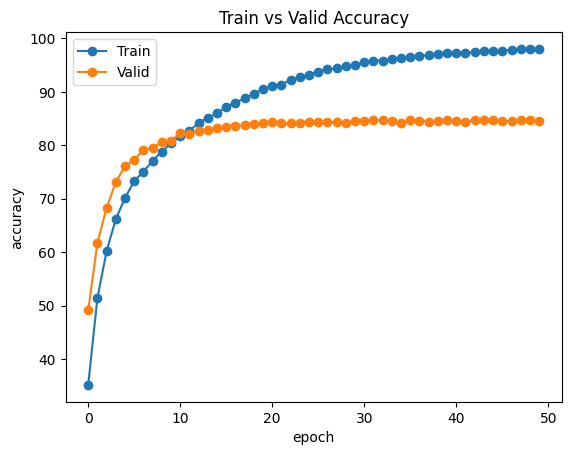

In [11]:
import matplotlib.pyplot as plt

#plot accuracy
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

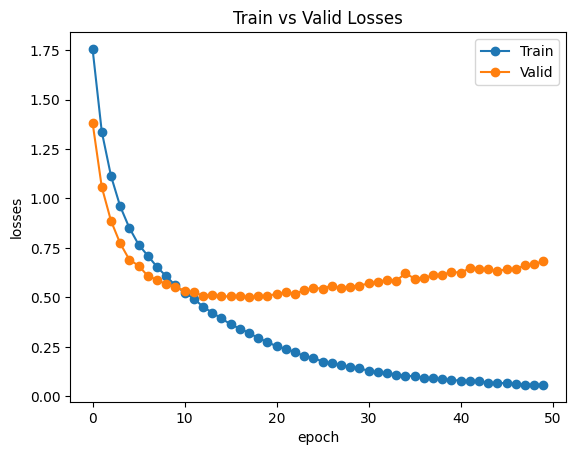

In [12]:
#plot losses
plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [13]:
y_true = []
y_pred = []

for data in tqdm(testloader):
  images,labels=data[0].to(device),data[1]  
  y_true.extend(labels.numpy())

  outputs=model(images)

  _, predicted = torch.max(outputs, 1)
  y_pred.extend(predicted.cpu().numpy())

100%|██████████| 313/313 [00:03<00:00, 88.89it/s]


In [14]:
print(y_pred)
print(y_true)

[3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 5, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 2, 2, 9, 4, 2, 4, 0, 9, 6, 6, 5, 2, 5, 9, 8, 4, 1, 9, 5, 4, 6, 3, 6, 0, 9, 3, 3, 7, 6, 9, 8, 3, 3, 8, 8, 7, 7, 4, 5, 7, 5, 6, 9, 6, 2, 1, 2, 3, 7, 2, 6, 8, 8, 0, 2, 0, 3, 5, 8, 8, 1, 1, 7, 2, 5, 2, 7, 8, 9, 0, 6, 8, 6, 4, 6, 6, 0, 0, 7, 7, 5, 6, 3, 1, 1, 3, 6, 8, 7, 4, 0, 2, 2, 1, 3, 0, 4, 6, 7, 8, 3, 1, 2, 8, 2, 8, 3, 6, 2, 4, 1, 8, 9, 1, 2, 9, 7, 2, 1, 6, 5, 6, 3, 8, 7, 6, 5, 5, 2, 8, 9, 6, 0, 0, 5, 2, 9, 3, 4, 2, 1, 6, 6, 8, 4, 8, 4, 7, 0, 9, 0, 9, 8, 9, 9, 3, 7, 5, 9, 0, 5, 2, 2, 0, 8, 6, 3, 3, 0, 5, 3, 0, 1, 7, 2, 8, 8, 7, 8, 3, 1, 8, 7, 1, 3, 0, 5, 7, 9, 7, 4, 5, 7, 8, 0, 7, 9, 8, 2, 7, 6, 9, 4, 4, 9, 4, 4, 7, 6, 5, 1, 3, 8, 8, 0, 4, 0, 5, 5, 1, 1, 8, 9, 0, 8, 1, 8, 4, 0, 5, 3, 9, 9, 2, 0, 3, 0, 8, 9, 8, 1, 5, 7, 1, 8, 2, 4, 7, 0, 2, 3, 6, 3, 8, 5, 0, 2, 4, 3, 9, 0, 6, 1, 9, 9, 1, 0, 7, 9, 1, 2, 6, 1, 3, 4, 6, 0, 0, 6, 6, 6, 5, 2, 6, 1, 8, 2, 1, 4, 8, 6, 0, 2, 4, 0, 7, 7, 5, 5, 3, 5, 2, 5, 4, 1, 7, 5, 4, 6, 1, 9, 6, 

In [15]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_true, y_pred)

In [16]:
import pandas as pd

class_names = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names) # Create pandas dataframe

In [17]:
dataframe

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
airplane,873,9,31,10,8,7,7,8,32,15
automobile,1,953,1,3,3,3,1,0,4,31
bird,43,1,773,31,43,37,40,23,6,3
cat,17,5,46,632,38,142,54,51,9,6
deer,10,2,45,28,818,26,30,35,4,2
dog,8,3,28,81,27,802,19,27,3,2
frog,4,2,20,25,17,12,909,5,4,2
horse,7,0,9,18,29,24,5,904,1,3
ship,43,16,4,7,0,5,2,2,910,11
truck,16,54,6,8,1,3,7,7,9,889


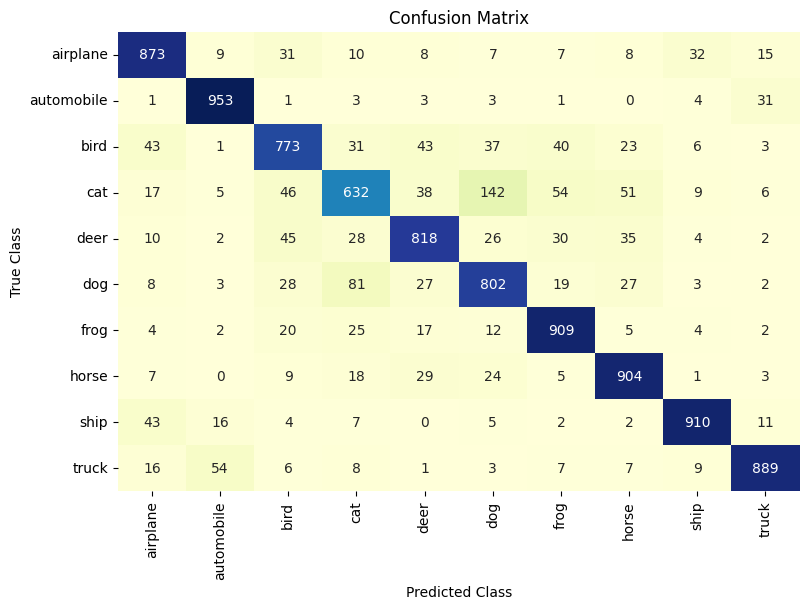

In [18]:
import seaborn as sns

plt.figure(figsize=(8, 6))

sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d") # Create heatmap

plt.title("Confusion Matrix"), plt.tight_layout()

plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()